In [ ]:
#importing libraries for model evaluation and algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#removing the neutral sentiments considering that positive and negative sentiments matter more 
df=df[df['airline_sentiment']!='neutral']
#now since neutral elements are deleted so I need to reset the indices
df.reset_index(inplace=True,drop=True)
#positive sentiments to 1 and negative to 0 
def partition(x):
    if x =='positive':
        return 1
    return 0
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    2363
Name: Sentiment, dtype: int64

In [ ]:
df.head()

In [ ]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [ ]:
#stops includes both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

In [ ]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
docs=[ clean(doc) for doc in docs]      

In [ ]:
#let's look at how our texts look after cleaning and position-tag lemmatization
docs[:5]

In [ ]:
df['text'][:5]

In [ ]:
#training involves our clean text as independent varaible and the predicted sentiments as the dependent variable 
X = np.array(docs)
Y = np.array(df['Sentiment'])
# splitting into train-test-validation set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.2, random_state=0)

In [ ]:
#looking at the shapes of each of the training, test and validation sets
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (7732,) (7732,)
X_test, Y_test (3809,) (3809,)
X_tr, Y_tr (6185,) (6185,)
X_cv, Y_cv (1547,) (1547,)


In [ ]:
#uses training and cross validation sets for hyperparameter tuning
def RF_Classifier(X_train,X_cv,Y_train,Y_cv):
    #appending auc scores of cross validation and training set in the below arrays respectively
    pred_cv = []
    pred_train = []
    #depths and estimators are hyperparameters which would be tuned here
    depths = [2, 3, 5, 8, 10, 20]
    estimators = [100, 200, 300, 400, 500]
    for i in depths:
        for j in estimators:
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, n_jobs = -1, class_weight='balanced')
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score for training data 
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators,yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()
    # representing heat map for auc score for validation set data
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depths),len(estimators))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=estimators, yticklabels=depths)
    plt.xlabel('Estimators')
    plt.ylabel('Depths')
    plt.show()

In [ ]:
#The below two lists are created to store auc and f1 scores respectively for all the vectorizations we are going to use 
AUC,F1=[],[]
#optimal depths and estimators determined by hyperparamter tuning
def testing(X_train,Y_train,X_test,Y_test,optimal_depth,optimal_estimator):
    clf = RandomForestClassifier(n_estimators = optimal_estimator, max_depth = optimal_depth,class_weight='balanced')
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    prediction=clf.predict(X_test)
    # keeping probabilities for the positive outcome only
    probs = prob[:, 1]
    print("AUC Score for test data",roc_auc_score(Y_test,probs))
    AUC.append(round(roc_auc_score(Y_test,probs),2))
    # calculate roc curve
    fpr_test, tpr_test, thresholds = roc_curve(Y_test,probs)
    # plot no skill function
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    #to plot a confusion matrix
    cm=confusion_matrix(Y_test,prediction)
    cm1 = pd.DataFrame(cm , index = ['positive','negative'] , columns = ['positive','negative'])
    plt.figure(figsize = (10,10))
    ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    ax.set(xlabel="Actual Sentiment", ylabel = "Predicted Sentiment")
    #printing f1 score and hamming loss
    print("f1 score for data :",metrics.f1_score(Y_test, prediction))
    F1.append(round(metrics.f1_score(Y_test, prediction),2))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

In [ ]:
#to create a wordcloud for the most important features/words
from wordcloud import WordCloud
def imp_feature(vectorizer,classifier, n =20):
    features = []
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
    top = coefs[:-(n + 1):-1]
    print('\033[1m' + "feature_importances\tfeatures" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-15s" % (coef1, feat1))
        features.append(feat1)
    wordcloud = WordCloud(background_color='black',width=1600,height=800).generate(" ".join(features))    #top 20 features in word cloud
    fig = plt.figure(figsize=(30,20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
#Bag Of Words Vectorization with unigrams and bigrams
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
# In below two lines we get a Bag of Word model that has cleaned the text, removing non-aphanumeric characters and stop words by the fitting part and 
# a matrix where each row represents a specific text in corpus and each column represents a word in vocabulary, that is, all words found in corpus
#from the transform
bow= count_vect.fit(X_tr)
bow_train = bow.transform(X_tr)
sum_words = bow_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in bow.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Top 20 words with their frequencies in training set are",words_freq[:20])
print("The type of count vectorizer ",type(bow_train))
#print("the number of unique words ", final_counts.get_shape()[1])
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Top 20 words with their frequencies in training set are [('united', 1846), ('flight', 1751), ('usairways', 1385), ('americanair', 1288), ('southwestair', 984), ('jetblue', 904), ('hour', 617), ('get', 591), ('service', 520), ('cancelled', 517), ('customer', 513), ('thanks', 506), ('time', 435), ('bag', 394), ('call', 386), ('help', 378), ('plane', 375), ('co', 340), ('http', 338), ('http co', 338)]
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [ ]:
#Normalize bow data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


------------------------------ AUC Score for train data ------------------------------


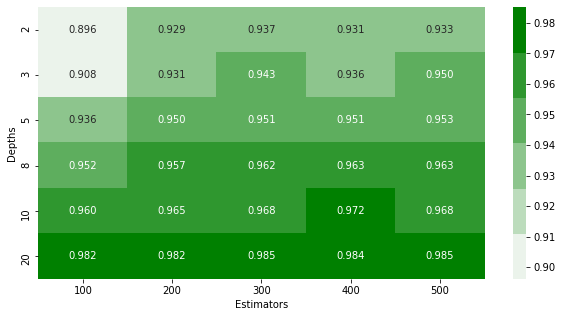

------------------------------ AUC Score for CV data ------------------------------


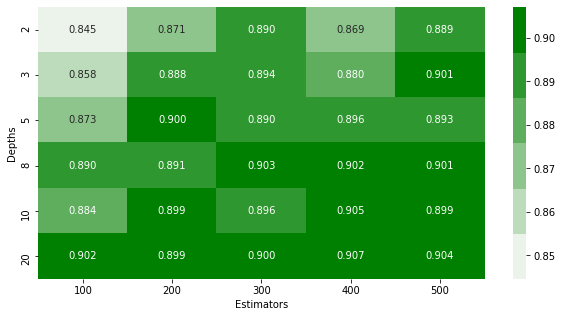

In [ ]:
# find optimal depth and optimal estimator
RF_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score for test data 0.9187215282758254


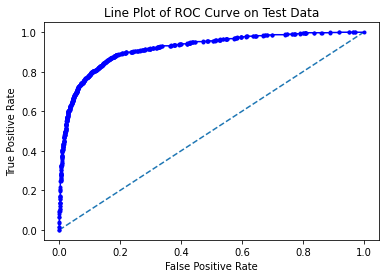

f1 score for data : 0.7020072053525477
hamming loss for data: 0.15200840115515885
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      3008
           1       0.60      0.85      0.70       801

    accuracy                           0.85      3809
   macro avg       0.78      0.85      0.80      3809
weighted avg       0.88      0.85      0.86      3809



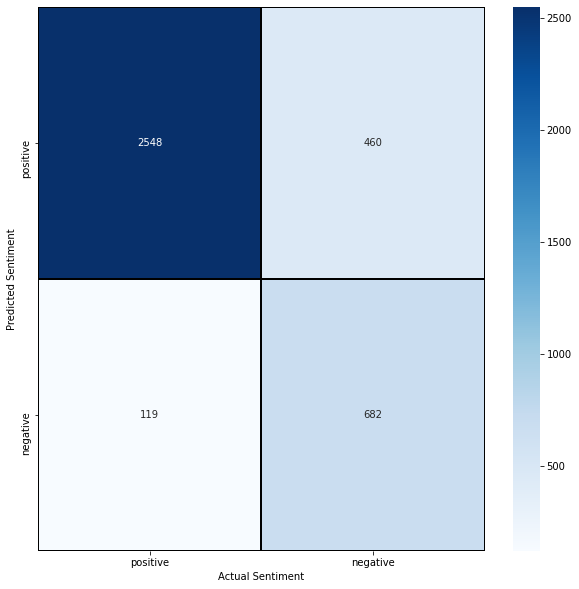

In [ ]:
# using optimal_depth and optimal_estimator for testing 
testing(bow_train,Y_tr,bow_test,Y_test,optimal_depth=8,optimal_estimator=400)

feature_importances	features
0.0286			thanks         
0.0263			thank          
0.0165			hour           
0.0139			usairways      
0.0137			great          
0.0130			jetblue        
0.0129			flight         
0.0126			cancelled flightled
0.0125			late           
0.0125			flightled      
0.0123			hold           
0.0117			best           
0.0109			cancelled      
0.0109			southwestair   
0.0101			jetblue thanks 
0.0097			call           
0.0094			good           
0.0088			amazing        
0.0084			united         
0.0078			virginamerica  


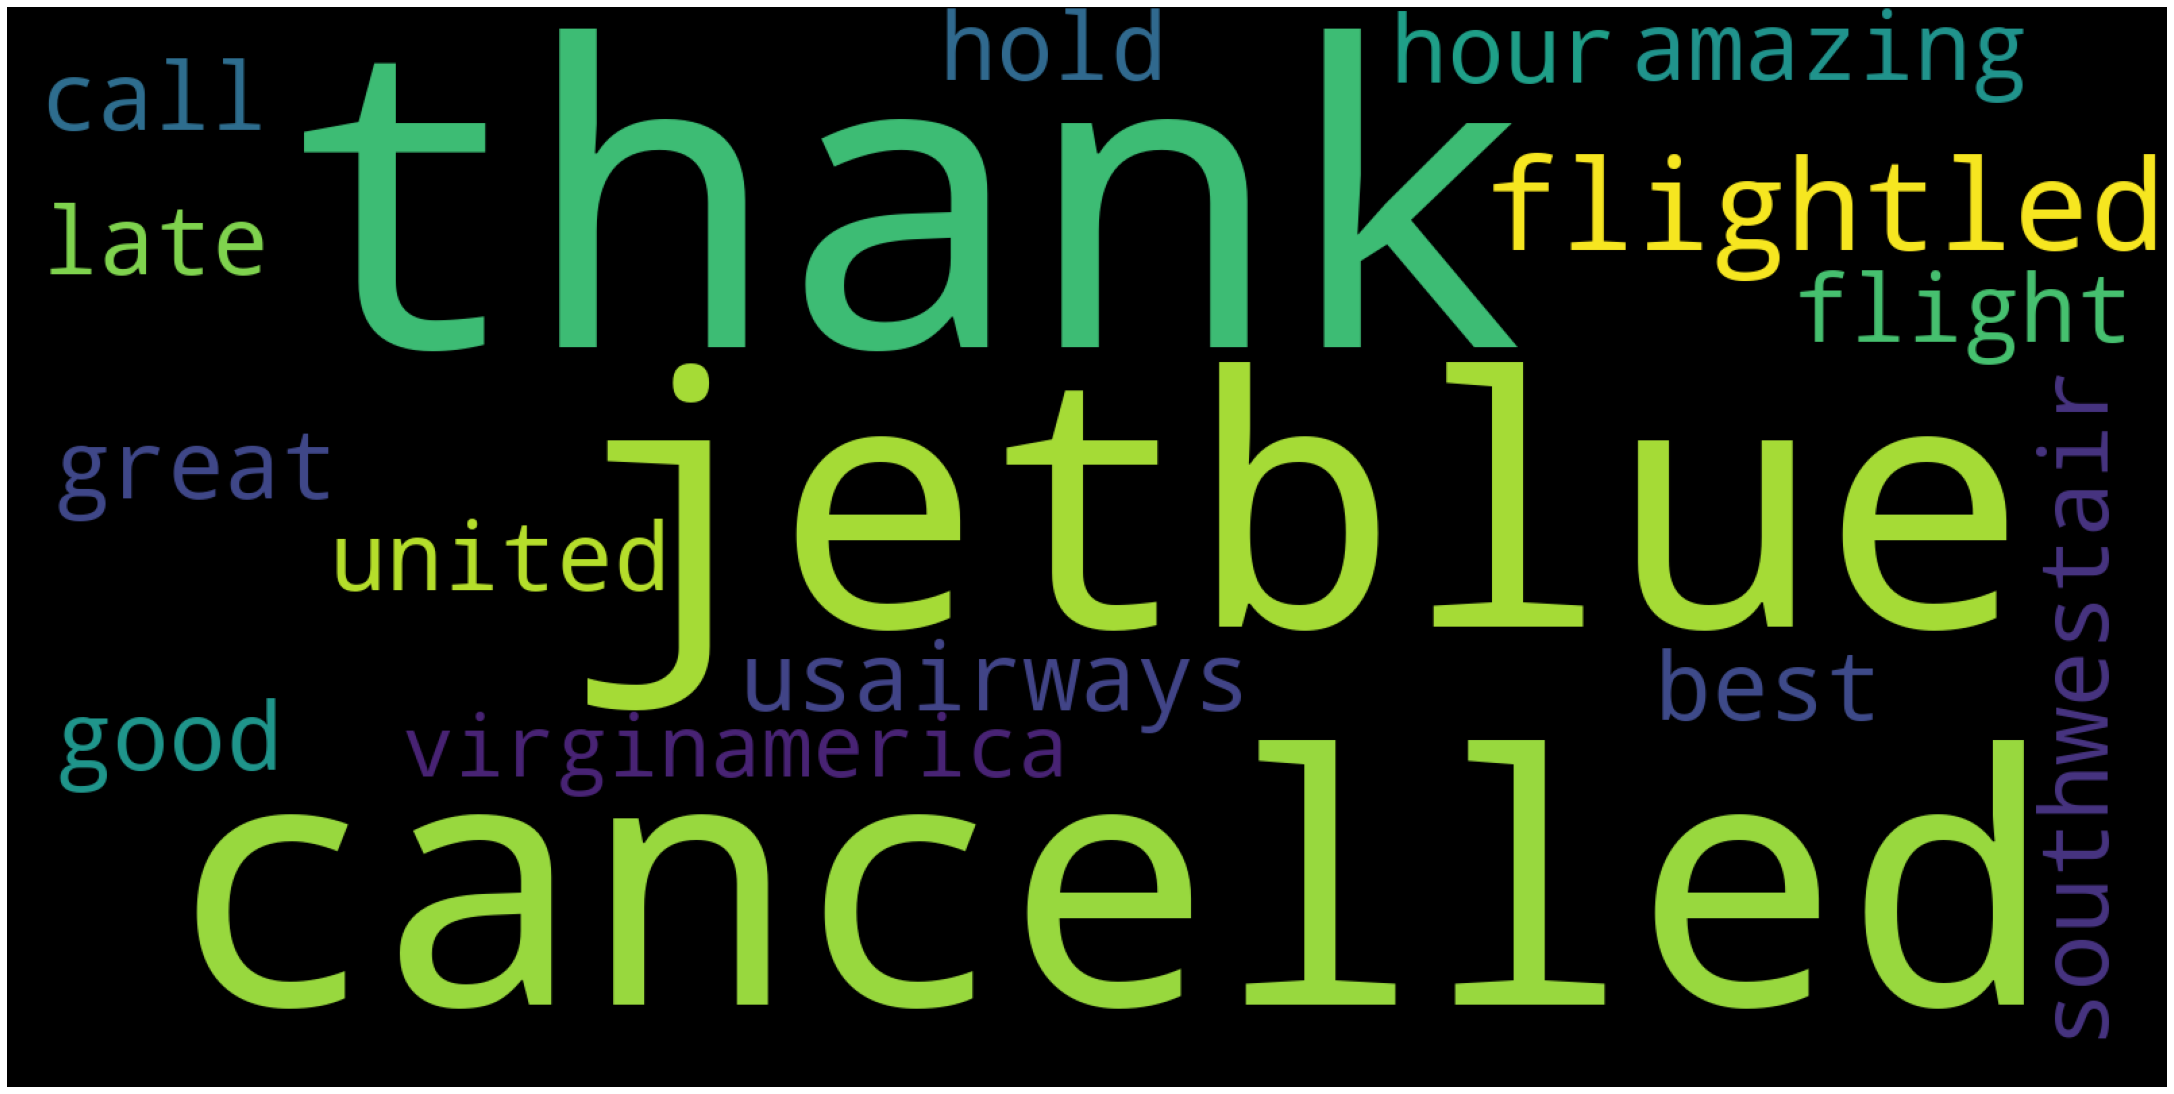

In [ ]:
#print top 20 features/words Random forest classifier and also plotting a word cloud
clf = RandomForestClassifier(max_depth =10, n_estimators = 400,class_weight='balanced')
clf.fit(bow_train,Y_tr)
features = imp_feature(count_vect,clf)

In [ ]:
#TF-IDF Vectorization with unigrams and bigrams
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])                                                              
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

some sample features(unique words in the corpus) ['cheapslogannotmotto', 'cheat', 'cheat go', 'cheatcustomers', 'cheated', 'cheated sorry', 'check', 'check 10', 'check 24', 'check 3rd']
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [ ]:
#displaying top 25 tfidf features/words
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,10)
top_tfidf

In [ ]:
#Normalize Data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


------------------------------ AUC Score for train data ------------------------------


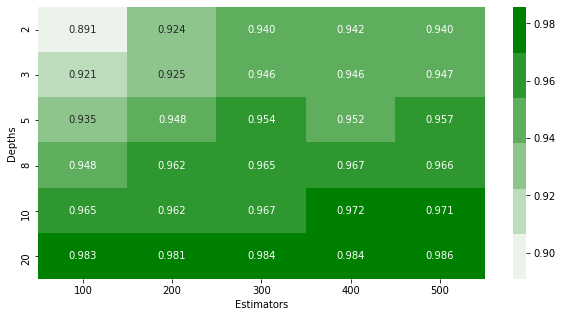

------------------------------ AUC Score for CV data ------------------------------


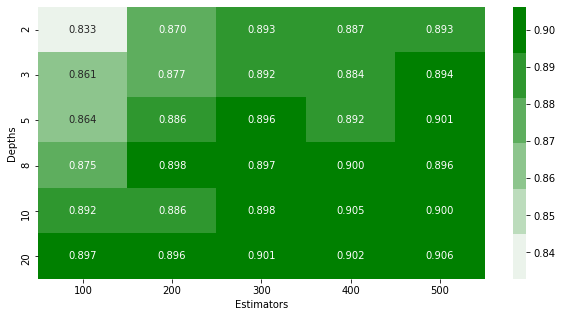

In [ ]:
# find optimal depth and optimal estimator for tfidf vectorizer
RF_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

AUC Score for test data 0.92193310555954


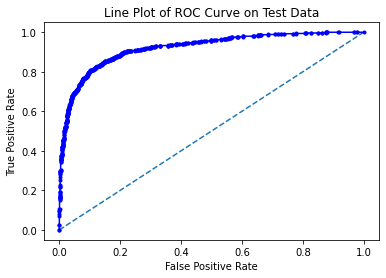

f1 score for data : 0.7064935064935066
hamming loss for data: 0.1483328957731688
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      3008
           1       0.60      0.85      0.71       801

    accuracy                           0.85      3809
   macro avg       0.78      0.85      0.80      3809
weighted avg       0.88      0.85      0.86      3809



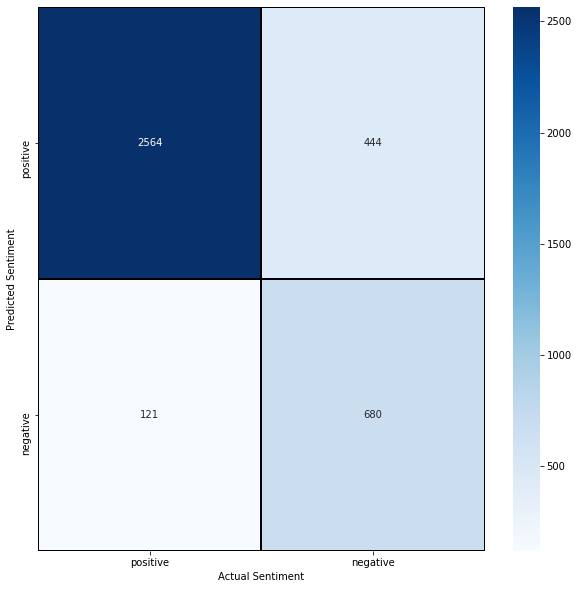

In [ ]:
# using optimal_depth and optimal_estimator for testing 
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_depth=8,optimal_estimator=300)

# **Word2Vec**

### Avg Word2Vec

In [ ]:
#importing word2vec from gensim
from gensim.models import Word2Vec

In [ ]:
#docs was the cleaned lemmatized text which has been appended into the dataframe for further use
df['CleanedText']=docs
df['CleanedText']=df['CleanedText'].str.decode("utf-8")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,Sentiment,CleanedText
0,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1,virginamerica plus 've added commercial experi...
1,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0,virginamerica 's really aggressive blast obnox...
2,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0,virginamerica 's really big bad thing
3,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),0,virginamerica seriously would pay 30 flight se...
4,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),1,virginamerica yes nearly every time fly vx “ e...


In [ ]:
#list of sent only contains the lemmatized cleaned text
list_of_sent=[]
for sent in df['CleanedText'].values:
    filtered_sentence=[]
    for w in sent.split():
            if(w.isalpha()):    
                filtered_sentence.append(w.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [ ]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [ ]:
#a sample w2v 50 dimensional vector of a word from my data 
w2v_model.wv['virginamerica']

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            #print('vec=',vec)
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [ ]:
# split avg-w2v vector data into Train, CV and Test
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(sent_vectors,Y, test_size=.2, random_state=0)
X_tr1, X_cv1, Y_tr1, Y_cv1 = train_test_split(X_train1, Y_train1, test_size=.33, random_state=0)
train_avgw2v=preprocessing.normalize(X_tr1)
cv_avgw2v=preprocessing.normalize(X_cv1)
test_avgw2v=preprocessing.normalize(X_test1)
print(train_avgw2v.shape)
print(cv_avgw2v.shape)
print(test_avgw2v.shape)
#print(len(X_train1)

(6185, 50)
(3047, 50)
(2309, 50)


------------------------------ AUC Score for train data ------------------------------


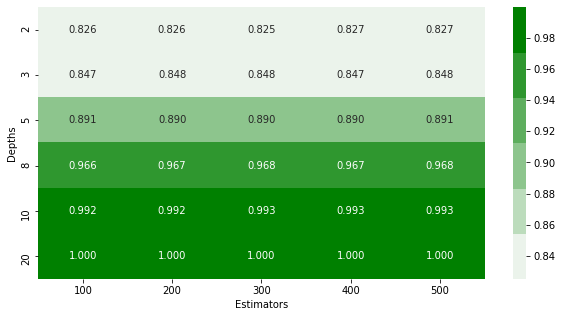

------------------------------ AUC Score for CV data ------------------------------


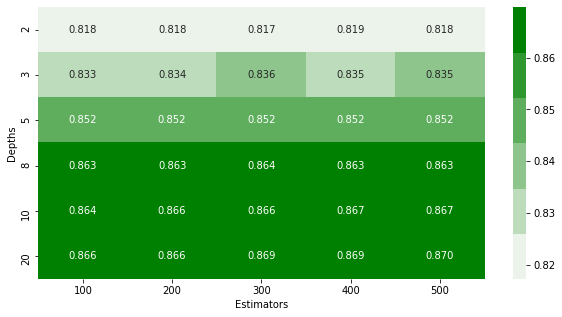

In [ ]:
# find optimal depth and optimal estimator using avg-w2v vectorizer
RF_Classifier(train_avgw2v,cv_avgw2v,Y_tr1,Y_cv1)

AUC Score for test data 0.8842733678109055


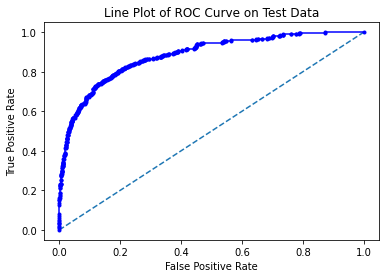

f1 score for data : 0.6558704453441295
hamming loss for data: 0.14724989172802078
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      1839
           1       0.63      0.69      0.66       470

    accuracy                           0.85      2309
   macro avg       0.77      0.79      0.78      2309
weighted avg       0.86      0.85      0.86      2309



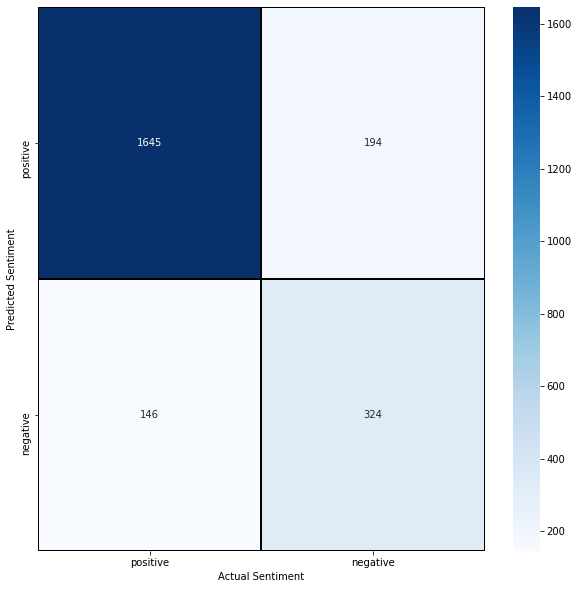

In [ ]:
# using optimal_depth and optimal_estimator for testing 
testing(train_avgw2v,Y_tr1,test_avgw2v,Y_test1,optimal_depth=8,optimal_estimator=300)

## TF-IDF Weighted Word2Vec

In [ ]:
#tfidf vectorization
tfidfw2v_vect = TfidfVectorizer()
tfidfw2v= tfidfw2v_vect.fit_transform(df['CleanedText'].values) 
print(type(tfidfw2v))
print(tfidfw2v.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(11541, 12022)


In [ ]:
# TF-IDF weighted Word2Vec
t=tfidfw2v_vect.get_feature_names()
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            #print('vec=',vec)
            tfidf = tfidfw2v[row,t.index(word)]
            sent_vec=sent_vec+(vec*tfidf)
            #print('sent=',sent_vec)
            cnt_words += tfidf
        except:
            pass
    sent_vec /= cnt_words
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
#train test split for tfidf-w2v vectorization
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(tfidf_sent_vectors,Y, test_size=0.2,random_state=0)
X_tr2, X_cv2, Y_tr2, Y_cv2 = train_test_split(X_train2, Y_train2, test_size=.33, random_state=0)
train_tfidfw2v=preprocessing.normalize(X_tr2)
cv_tfidfw2v=preprocessing.normalize(X_cv2)
test_tfidfw2v=preprocessing.normalize(X_test2)
print(train_tfidfw2v.shape)
print(cv_tfidfw2v.shape)
print(test_tfidfw2v.shape)

(6185, 50)
(3047, 50)
(2309, 50)


------------------------------ AUC Score for train data ------------------------------


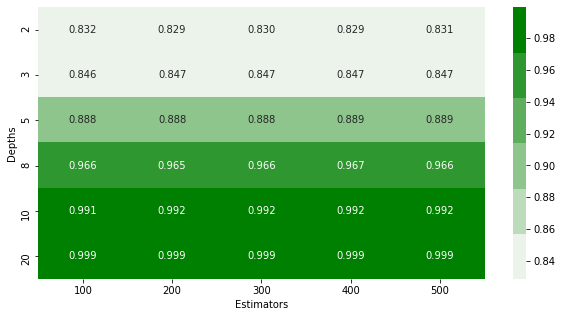

------------------------------ AUC Score for CV data ------------------------------


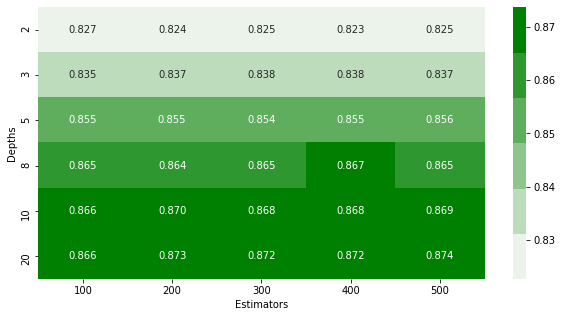

In [ ]:
# find optimal depth and optimal estimator using tfidf-w2v vectorization
RF_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr2,Y_cv2)

AUC Score for test data 0.8823562759594137


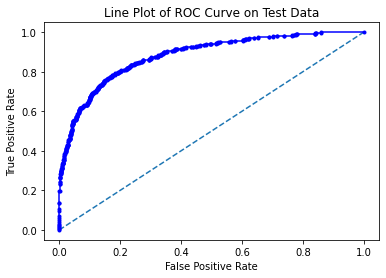

f1 score for data : 0.6488294314381271
hamming loss for data: 0.1364226938068428
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      1839
           1       0.68      0.62      0.65       470

    accuracy                           0.86      2309
   macro avg       0.79      0.77      0.78      2309
weighted avg       0.86      0.86      0.86      2309



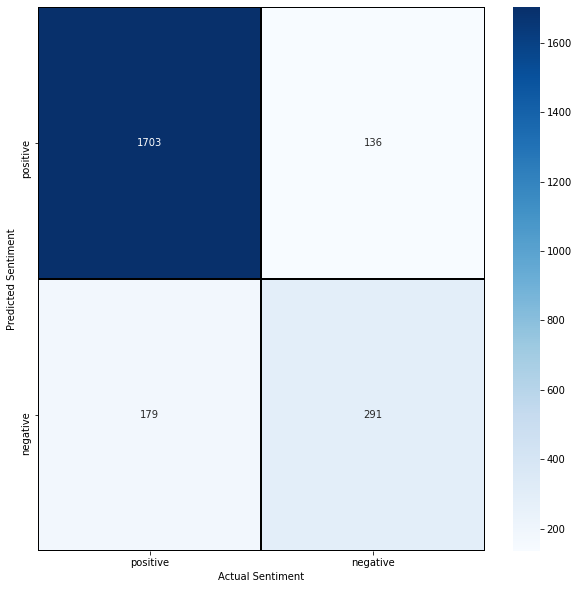

In [ ]:
#using optimal_depth and optimal_estimator for testing
testing(train_tfidfw2v,Y_tr2,test_tfidfw2v,Y_test2,optimal_depth=10,optimal_estimator=400)

In [ ]:
#Here I have displayed how the Random Forest performed for both BOW ,TF-IDF and W2V Vectorizations
from IPython.display import display
 # intialise data of lists.
data = {'Category':['BOW Vectorization','TF-IDF Vectorization','W2V-AVG Vectorization','W2V-TFIDF Vectorization'],
        'AUC Score':AUC,
        'F1-Score':F1}
df = pd.DataFrame(data)
 
# Print the output.
display(df)      

,Category,AUC Score,F1-Score
0,BOW Vectorization,0.92,0.70
1,TF-IDF Vectorization,0.92,0.71
2,W2V-AVG Vectorization,0.88,0.66
3,W2V-TFIDF Vectorization,0.88,0.65
